# Weekly Pattern Construction using SGD

This notebook demonstrates how to use Stochastic Gradient Descent (SGD) to construct weekly patterns from time series data. The goal is to identify and extract patterns that repeat on a weekly basis.

First, we need to import the necessary libraries and modules. Make sure you have the required packages installed in your Python environment.

Secondly, we will define the parameters for each day of the week. The parameters include the base concentration, amplitudes, sigmas, and alphas for the Gaussian components that will be used to model the demand patterns.

The parameters are defined for each day of the week, including Sunday to Thursday (3 peaks), Friday (evening peak), and Saturday (2 significant peaks). The data is generated using a composite model that combines these Gaussian components.

Finally, we will visualize the weekly pattern and save the results to an Excel file for further analysis.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from composite_and_fit_model import composite_model
from SGD_patterns_decomposition import store_results
from skewed_gaussian import single_gaussian



## Define parameters for each day

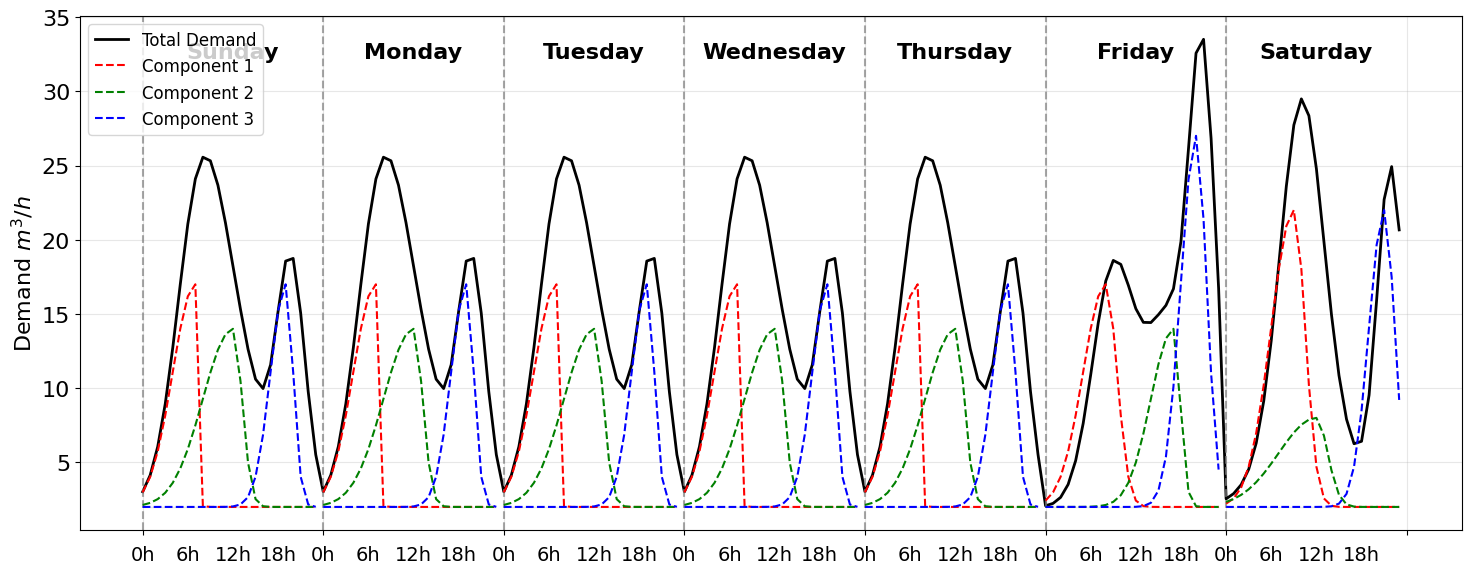

In [3]:

# Define parameters for each day
# Sunday to Thursday: 3 peaks (e.g., morning, noon, evening)
sun_thu_peaks = np.array([7, 12, 19])  # Hours: 7:00, 12:00, 19:00
sun_thu_params = {
    'C_base': 2.0,
    'amplitudes': np.array([15.0, 12.0, 15.0]),
    'sigmas': np.array([3, 4.0, 2.0]),
    'alphas': np.array([0.1, -0.3, 0.5])
}

# Friday: Evening peak concentration
fri_peaks = np.array([8, 17, 20])  # Hour: 18:00
fri_params = {
        'C_base': 2.0,
    'amplitudes': np.array([15.0, 12.0, 20.0]),
    'sigmas': np.array([3, 3.0, 2.0]),
    'alphas': np.array([0.5, -0.3, 0.7])
    }

# Saturday: 2 significant peaks (morning and evening)
sat_peaks = np.array([9, 12, 21])  # Hours: 9:00, 20:00
sat_params = {
        'C_base': 2.0,
    'amplitudes': np.array([20.0, 6.0, 20.0]),
    'sigmas': np.array([3, 5.0, 2.0]),
    'alphas': np.array([0.5, -0.3, 0.7])
    }



## Create a list of days in correct order: Sunday to Saturday


In [ ]:
# Create a list of days in correct order: Sunday to Saturday
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


## Generate data for each day

In [ ]:

days_data = {}
for day in day_order:
    if day == 'Friday':
        peaks, params = fri_peaks, fri_params
    elif day == 'Saturday':
        peaks, params = sat_peaks, sat_params
    else:
        peaks, params = sun_thu_peaks, sun_thu_params

    day_hours = np.arange(0, 24)
    y = composite_model(day_hours, peaks, params['C_base'], params['amplitudes'], params['sigmas'], params['alphas'])
    days_data[day] = pd.DataFrame({'day': day, 'demand': y, 'hours': list(range(24))})

# Concatenate all days into a single DataFrame, maintaining the order
df_week = pd.concat([days_data[day] for day in day_order], ignore_index=True)

# Store results for each day
results = {}
for day in day_order:
    df_day = days_data[day]
    y = df_day['demand'].values

    if day == 'Friday':
        peaks = fri_peaks
    elif day == 'Saturday':
        peaks = sat_peaks
    else:
        peaks = sun_thu_peaks

    # Note: This might need adjustment based on your store_results function
    results[day] = store_results(df_day, y, peaks,
                                 params['C_base'], params['amplitudes'],
                                 params['sigmas'], params['alphas'])





## Plot the weekly pattern

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_week.index, df_week['demand'], label='Total Demand', linewidth=2, color='black')
# plt.title('Weekly Water Demand Pattern (SGD) with Individual Gaussian Components', fontsize=14)
# plt.xlabel('Hours (Sunday to Saturday)', fontsize=12)
plt.ylabel('Demand $m^{3}/h$') ############################
plt.grid(True, alpha=0.3)

# Add vertical dashed lines to separate days and label them properly
day_boundaries = [0] + [24 * (i + 1) for i in range(7)]
for i, boundary in enumerate(day_boundaries[:-1]):
    # Add vertical line at the start of each day
    plt.axvline(x=boundary, color='grey', linestyle='--', alpha=0.7)

    # Add day label centered in each day's range
    day_center = boundary + 12
    day_name = day_order[i]
    plt.text(day_center, plt.ylim()[1] * 0.95, day_name,
             horizontalalignment='center', verticalalignment='top',
             fontweight='bold')

# Add individual Gaussian components with different colors
peak_colors = ['red', 'green', 'blue', 'purple', 'orange']
component_labels = []

# Process each day and add individual Gaussian components
for day_idx, day in enumerate(day_order):
    start_hour = day_idx * 24
    day_hours = np.arange(0, 24)

    # Select the appropriate peaks and parameters based on the day
    if day == 'Friday':
        current_peaks = fri_peaks
        current_params = fri_params
    elif day == 'Saturday':
        current_peaks = sat_peaks
        current_params = sat_params
    else:
        current_peaks = sun_thu_peaks
        current_params = sun_thu_params

    # Plot base value
    plt.hlines(y=current_params['C_base'], xmin=start_hour, xmax=start_hour + 23,
               colors='lightgrey', linestyles='solid', linewidth=1, alpha=0.5)

    # Add each individual Gaussian component
    for peak_idx, peak_hour in enumerate(current_peaks):
        color_idx = peak_idx % len(peak_colors)
        color = peak_colors[color_idx]

        # Calculate the individual Gaussian component
        gaussian_y = single_gaussian(
            day_hours,
            peak_hour,
            current_params['amplitudes'][peak_idx],
            current_params['sigmas'][peak_idx],
            current_params['alphas'][peak_idx]
        )

        # Add the base value to the Gaussian component
        gaussian_y += current_params['C_base']

        # Plot the individual Gaussian component
        x_values = np.arange(start_hour, start_hour + 24)
        plt.plot(x_values, gaussian_y, '--', color=color, linewidth=1.5)

        # Add component label only once to the legend
        component_label = f"Component {peak_idx + 1}"
        if component_label not in component_labels:
            plt.plot([], [], '--', color=color, linewidth=1.5, label=component_label)
            component_labels.append(component_label)

# Add tick marks at the start of each day
plt.xticks(day_boundaries, [''] * len(day_boundaries))

# Add hour labels below x-axis
hours_per_tick = 6
for day_idx, day in enumerate(day_order):
    start_hour = day_idx * 24
    for h in range(0, 24, hours_per_tick):
        plt.text(start_hour + h, plt.ylim()[0] - 2, f"{h}h",
                 horizontalalignment='center', fontsize=14)

plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Save the DataFrame to an Excel file

In [ ]:
output_file = 'weekly_water_demand_pattern.xlsx'
df_week.to_excel(output_file, index=False)